In [1]:
!pip install transformers datasets scikit-learn pandas seaborn matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    f1_score, precision_recall_fscore_support
)
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)

# Load SemEval-style sentiment dataset
dataset = load_dataset("tweet_eval", "sentiment")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }

def plot_confusion_matrix(y_true, y_pred, model_name):
    labels = ["Negative", "Neutral", "Positive"]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_class_metrics(y_true, y_pred, model_name):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    labels = ["Negative", "Neutral", "Positive"]
    x = np.arange(len(labels))
    plt.figure(figsize=(8, 5))
    plt.bar(x, precision, width=0.25, label='Precision')
    plt.bar(x + 0.25, recall, width=0.25, label='Recall')
    plt.bar(x + 0.50, f1, width=0.25, label='F1 Score')
    plt.xticks(x + 0.25, labels)
    plt.title(f"Per-Class Metrics - {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_pred, model_name):
    labels = ["Negative", "Neutral", "Positive"]
    counts = np.bincount(y_pred, minlength=3)
    plt.bar(labels, counts, color="skyblue")
    plt.title(f"Prediction Distribution - {model_name}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def plot_loss_curves(trainer, model_name):
    logs = trainer.state.log_history
    train_loss = [x['loss'] for x in logs if 'loss' in x and 'eval_loss' not in x]
    eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]
    plt.plot(train_loss[:len(eval_loss)], label="Train Loss")
    plt.plot(eval_loss, label="Eval Loss")
    plt.title(f"Loss Curves - {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

tokenized = dataset.map(preprocess, batched=True)
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

training_args = TrainingArguments(
    output_dir="./results/bert-base",
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    compute_metrics=compute_metrics
)

trainer.train()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.638000,0.597654,0.736500,0.736905
2,0.497300,0.635898,0.742500,0.739944
3,0.295900,0.789283,0.744500,0.744010


TrainOutput(global_step=8553, training_loss=0.47243596830661294, metrics={'train_runtime': 12054.7271, 'train_samples_per_second': 11.352, 'train_steps_per_second': 0.71, 'total_flos': 3.600575564898816e+16, 'train_loss': 0.47243596830661294, 'epoch': 3.0})

              precision    recall  f1-score   support

    Negative       0.71      0.70      0.70      3972
     Neutral       0.70      0.66      0.68      5937
    Positive       0.63      0.73      0.68      2375

    accuracy                           0.69     12284
   macro avg       0.68      0.70      0.69     12284
weighted avg       0.69      0.69      0.69     12284



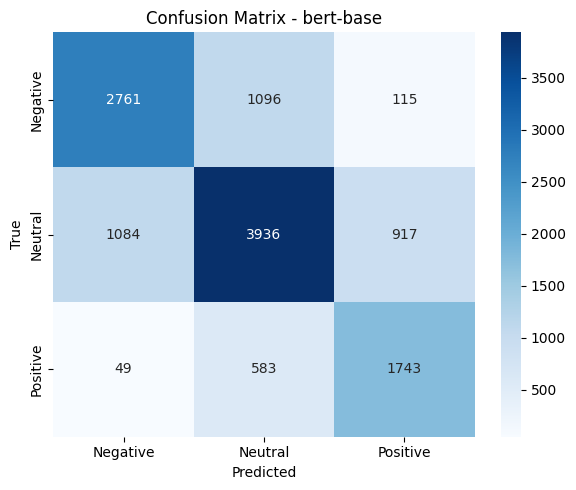

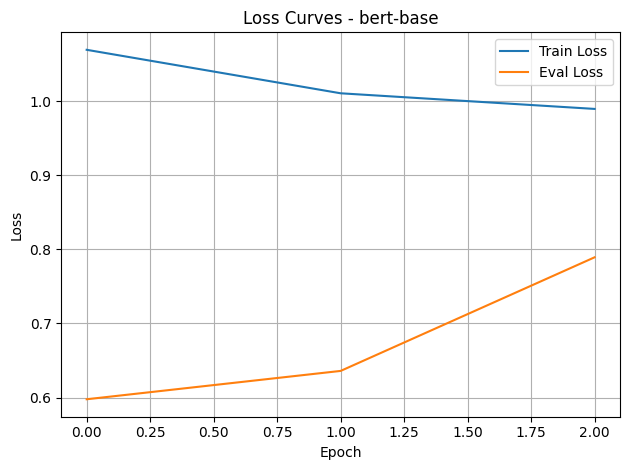

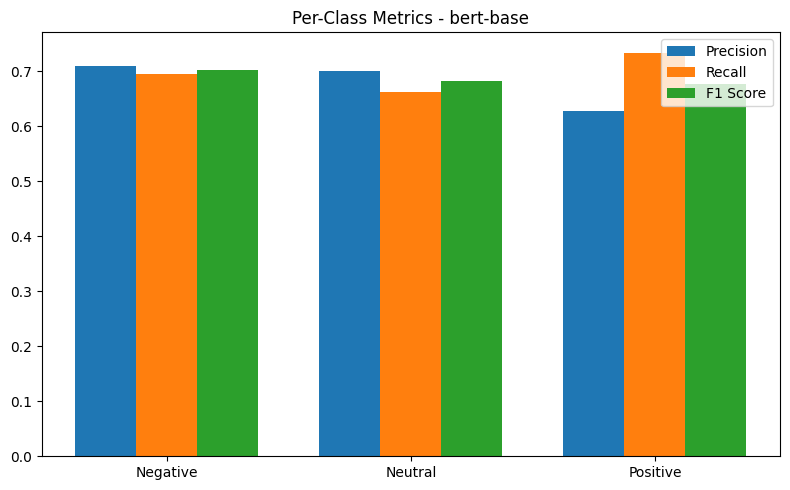

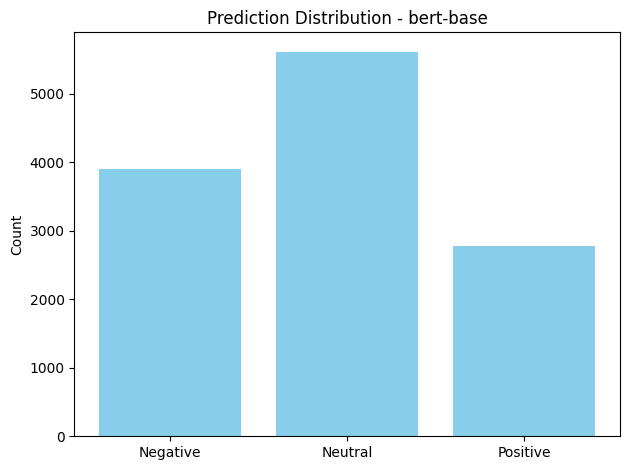

In [ ]:
# Evaluate on test set
preds = trainer.predict(tokenized["test"])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

# Text report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Visuals
plot_confusion_matrix(y_true, y_pred, "bert-base")
plot_loss_curves(trainer, "bert-base")
plot_class_metrics(y_true, y_pred, "bert-base")
plot_prediction_distribution(y_pred, "bert-base")


In [4]:
# RoBERTa-base
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

tokenized = dataset.map(preprocess, batched=True)
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

training_args = TrainingArguments(
    output_dir="./results/roberta-base",
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    compute_metrics=compute_metrics
)

trainer.train()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.636000,0.590674,0.737500,0.739131
2,0.520500,0.604158,0.752500,0.748991
3,0.357400,0.676539,0.745000,0.744593


TrainOutput(global_step=8553, training_loss=0.5111154326079088, metrics={'train_runtime': 12430.4022, 'train_samples_per_second': 11.009, 'train_steps_per_second': 0.688, 'total_flos': 3.600575564898816e+16, 'train_loss': 0.5111154326079088, 'epoch': 3.0})

              precision    recall  f1-score   support

    Negative       0.71      0.77      0.74      3972
     Neutral       0.75      0.64      0.69      5937
    Positive       0.64      0.78      0.70      2375

    accuracy                           0.71     12284
   macro avg       0.70      0.73      0.71     12284
weighted avg       0.72      0.71      0.71     12284



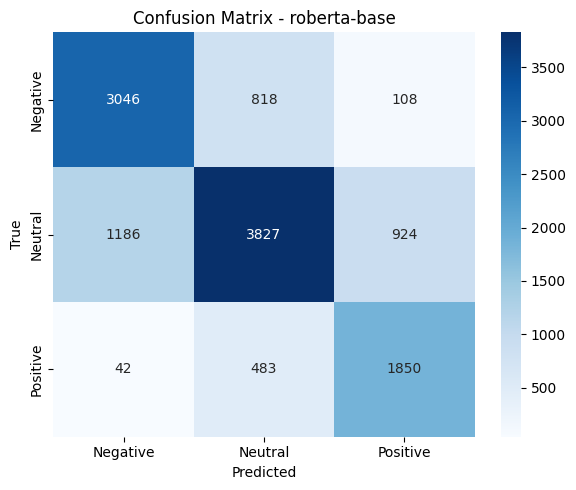

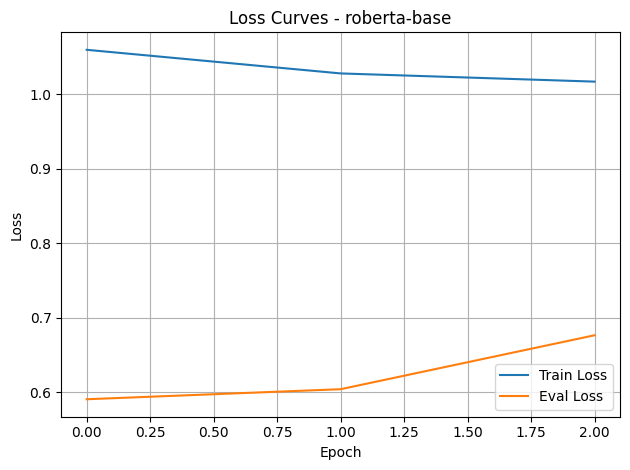

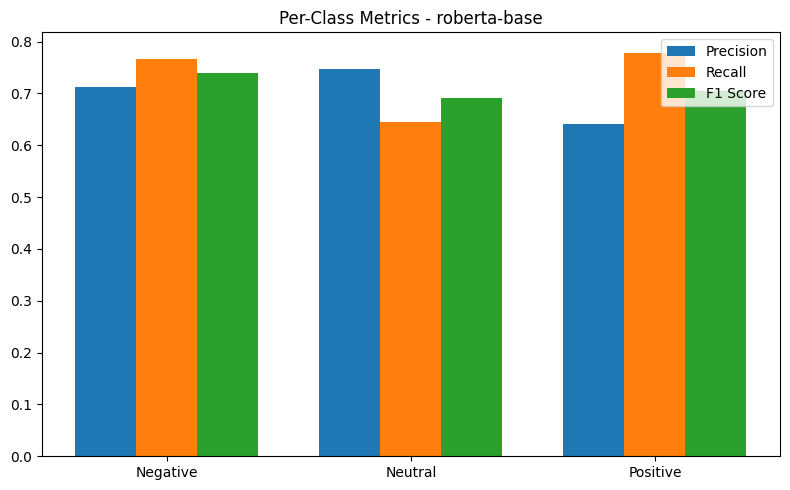

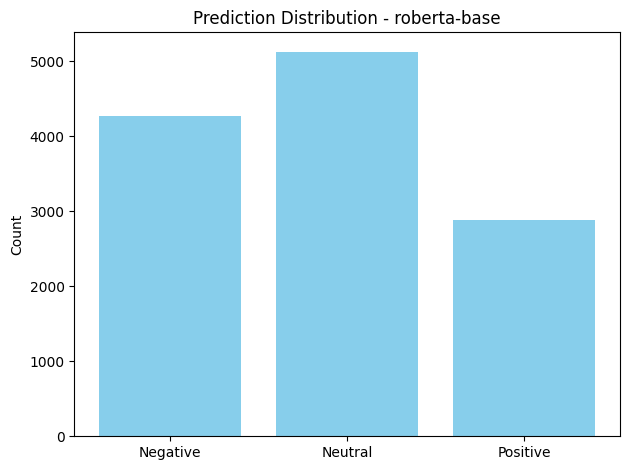

In [5]:
# Evaluate on test set
preds = trainer.predict(tokenized["test"])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

# Text report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Visuals for RoBERTa-base
plot_confusion_matrix(y_true, y_pred, "roberta-base")
plot_loss_curves(trainer, "roberta-base")
plot_class_metrics(y_true, y_pred, "roberta-base")
plot_prediction_distribution(y_pred, "roberta-base")


In [ ]:
# BERTweet-base (Fixed for consistent padding)
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# ✅ FIXED: Added max_length and padding explicitly
def preprocess(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=64  # Fixed max length suitable for tweets
    )

# Tokenize the dataset
tokenized = dataset.map(preprocess, batched=True)
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results/bertweet-base",
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    report_to="none"
)

# Setup trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    compute_metrics=compute_metrics
)

# 🚀 Train the model
trainer.train()


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.625100,0.582600,0.749000,0.749930
2,0.509700,0.635352,0.757000,0.753792
3,0.361200,0.686688,0.750500,0.749593


TrainOutput(global_step=8553, training_loss=0.4791798298782345, metrics={'train_runtime': 2095.1093, 'train_samples_per_second': 65.316, 'train_steps_per_second': 4.082, 'total_flos': 4500719456123520.0, 'train_loss': 0.4791798298782345, 'epoch': 3.0})

              precision    recall  f1-score   support

    Negative       0.71      0.79      0.75      3972
     Neutral       0.75      0.66      0.70      5937
    Positive       0.68      0.75      0.71      2375

    accuracy                           0.72     12284
   macro avg       0.71      0.73      0.72     12284
weighted avg       0.72      0.72      0.72     12284



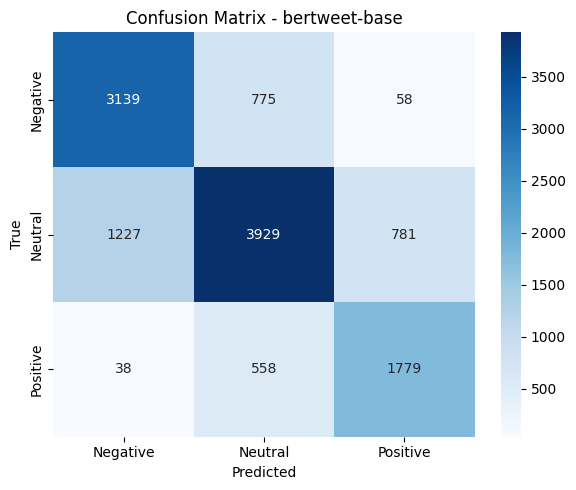

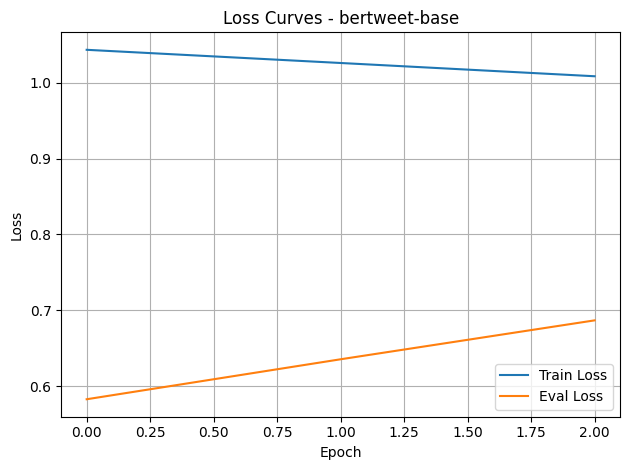

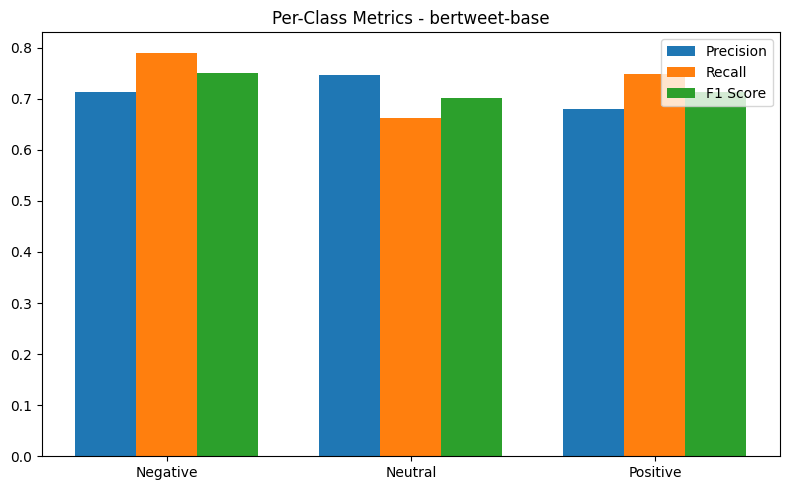

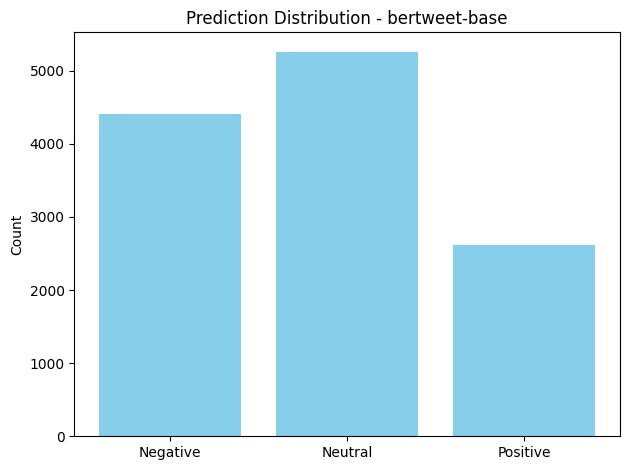

In [ ]:
# Evaluate BERTweet on the test set
preds = trainer.predict(tokenized["test"])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Visuals for BERTweet
plot_confusion_matrix(y_true, y_pred, "bertweet-base")
plot_loss_curves(trainer, "bertweet-base")
plot_class_metrics(y_true, y_pred, "bertweet-base")
plot_prediction_distribution(y_pred, "bertweet-base")
